In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'1.2.1'

In [3]:
#convolutional layer 1
filter_size1 = 5
num_filters1 = 16
#convolutional layer 2
filter_size2 = 5
num_filters2 = 36
#fully-connected layer
fc_size = 128

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [7]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = 'True:{0}'.format(cls_true[i])
        else:
            xlabel = 'True:{0}, Pred:{1}'.format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

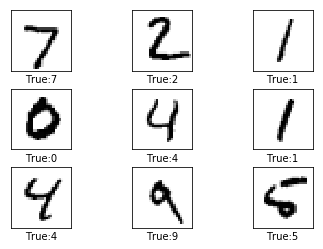

In [9]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size, 
                   num_filters, 
                   use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input, 
                         filter=weights, 
                         strides=[1, 1, 1, 1], 
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [13]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [14]:
def new_fc_layer(input, 
                 num_inputs, 
                 num_outputs, 
                 use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input,weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true,dimension=1)

In [16]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, 
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

In [17]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [18]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

In [19]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [20]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [21]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [22]:
num_features

1764

In [23]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [24]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [25]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [26]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [27]:
y_pred = tf.nn.softmax(layer_fc2)

In [28]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)

In [30]:
cost = tf.reduce_mean(cross_entropy)

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [32]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [33]:
session = tf.Session()

In [34]:
session.run(tf.global_variables_initializer())

In [35]:
train_batch_size = 64

In [36]:
total_iterations = 0

In [37]:
def optimize(num_iterations):
    global total_iterations
    start_time=time.time()
    for i in range(total_iterations, 
                   total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x:x_batch, 
                           y_true:y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
    
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = 'Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}'
            print(msg.format(i + 1, acc))
    
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))))    

In [38]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct==False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [52]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [40]:
test_batch_size = 256

In [41]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x:images, y_true:labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [42]:
print_test_accuracy()

Accuracy on Test-Set: 8.7% (868 / 10000)


In [43]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  18.8%
Time usage: 0:00:00


In [44]:
print_test_accuracy()

Accuracy on Test-Set: 9.4% (943 / 10000)


In [45]:
optimize(num_iterations=99)

Time usage: 0:00:01


Accuracy on Test-Set: 67.3% (6732 / 10000)
Example errors:


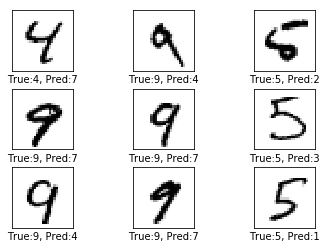

In [46]:
print_test_accuracy(show_example_errors=True)

In [47]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  75.0%
Optimization Iteration:    201, Training Accuracy:  79.7%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  84.4%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  96.9%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  93.8%
Time usage: 0:00:07


In [48]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  90.6%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  90.6%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  93.8%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy:  95.3%
Optimization I

Accuracy on Test-Set: 98.9% (9885 / 10000)
Example errors:


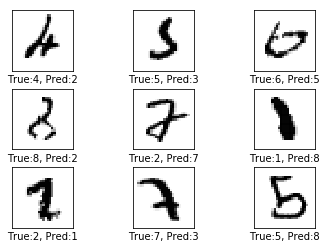

Confusion Matrix:
[[ 970    0    2    0    0    2    2    1    2    1]
 [   0 1125    3    0    0    1    2    2    2    0]
 [   1    1 1025    0    1    0    0    2    2    0]
 [   0    0    0 1005    0    2    0    0    2    1]
 [   0    0    1    0  978    0    0    0    0    3]
 [   0    0    1    5    0  882    1    0    1    2]
 [   2    1    0    0    2    9  944    0    0    0]
 [   0    1    8    4    0    0    0 1008    1    6]
 [   1    0    2    7    1    3    0    2  952    6]
 [   0    2    0    1    5    4    0    1    0  996]]


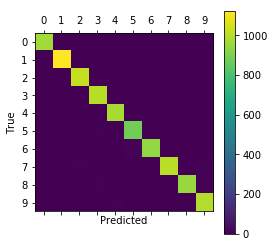

In [53]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [55]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [56]:
def plot_conv_layer(layer, image):
    feed_dict = {x:[image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [57]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
              interpolation='nearest',
              cmap='binary')
    plt.show()

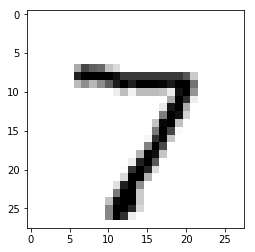

In [58]:
image1 = data.test.images[0]
plot_image(image1)

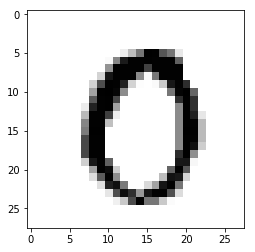

In [59]:
image2 = data.test.images[13]
plot_image(image2)

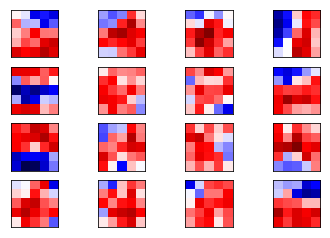

In [60]:
plot_conv_weights(weights=weights_conv1)

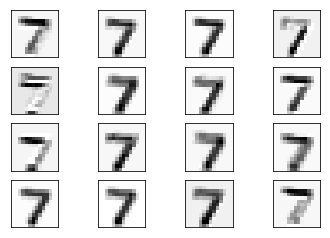

In [61]:
plot_conv_layer(layer=layer_conv1, image=image1)

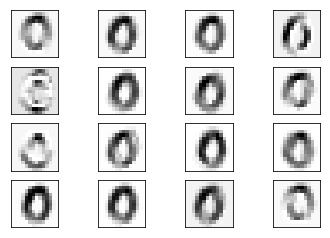

In [62]:
plot_conv_layer(layer=layer_conv1, image=image2)

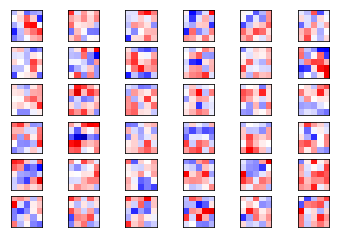

In [63]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

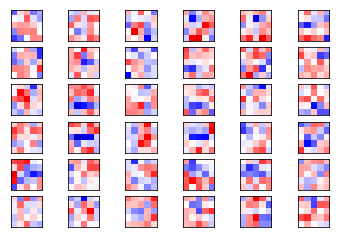

In [64]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

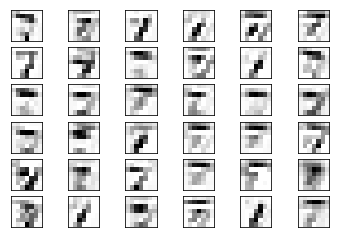

In [65]:
plot_conv_layer(layer=layer_conv2, image=image1)

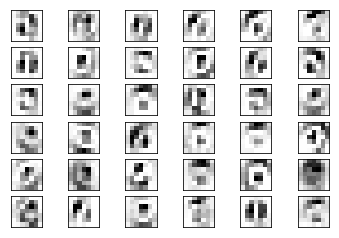

In [66]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [67]:
session.close()